In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import h5py

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Group 4/

/content/drive/.shortcut-targets-by-id/1-A7MSZ6V8eP_xZaDJ_j7yN9ddVL8-jgm/Group 4


Function to list patient names

In [4]:
def list_patient_names(root):

    patient_list = sorted([item for item in os.listdir(root) 
                           if os.path.isdir(os.path.join(root, item))],
                           key = lambda x: x[4:])
    
    return patient_list

Function to list trial files

In [5]:
def list_trial_files(root, patient_name):
    
    patient_folder = root + patient_name + "/"
    
    trial_names = sorted([f for f in os.listdir(patient_folder) 
                          if os.path.isfile(os.path.join(patient_folder, f))])
    
    return trial_names

Function to read in patient name, patient type, trial number, stimulus type, sensor name

In [6]:
def parse_dat(root, patient_name, trial_file):
    
    txtfile = root + patient_name + "/" + trial_file
    
    # Read in the entire data file
    lines = []

    with gzip.open(txtfile,'rt') as f:
        for line in f:
            lines.append(line)
            
    # Get the patient name
    patient_name = lines[0].split(' ')[1][:-4]
    
    # Get patient type (alcoholic or control)
    patient_type = patient_name[3]
    
    # Get trial number
    trial_num = trial_file[-6:-3]
    
    # Get stimulus type
    stim_type = lines[3].split(' ')[1] + ' ' + lines[3].split(' ')[2]
    
    # Get sensor names
    readings = lines[4:]
    headers = [r for r in readings if r[0]=='#']
    sensor_names = [h.split(' ')[1] for h in headers]
        
    # Get sensor readings for all 64 detectors for all 256 timestamps
    data = [r for r in readings if r[0]!='#']
    
    data_mat = np.zeros((64, 256))
    
    for i in range(64):
        for j in range(256):
            data_mat[i, j] = float(data[i*256+j].split(' ')[3][:-1])
            
    return patient_name, patient_type, trial_num, stim_type, sensor_names, data_mat

Load in all the data

In [7]:
root = os.getcwd()

In [8]:
data_path = root + '/eeg_full/'

In [9]:
df = pd.read_csv(data_path+'S1_patient_summary.csv')
hf = h5py.File(data_path+'S1.h5', 'r')

In [10]:
df['Type'] = df['Type'].replace({'c':0, 'a':1})

In [11]:
dat_tensor = np.zeros((len(df), 64, 256))

In [12]:
dat_targets = np.zeros(len(df))

In [13]:
for i in range(len(df)):
    
    pat = df.iloc[i]['Patient']
    tri = '%03d'%df.iloc[i]['Trial']
    
    fname = pat+'.rd.'+tri
    
    dat = np.array(hf.get(fname))
    
    dat_tensor[i] = dat
    dat_targets[i] = df.iloc[i]['Type']

Split training and testing data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_tensor, test_tensor, train_target, test_target = train_test_split(
                                            dat_tensor, dat_targets, test_size=0.2, random_state=0)

Load the neural network

In [16]:
# For loading the neural network
import tensorflow as tf
from tensorflow import keras

In [17]:
model_path = root + '/Models/S1/'
model_name = model_path + 'cnn_save_S1'
model = keras.models.load_model(model_name)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 237, 23)       2323      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 19, 23)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8740)              0         
                                                                 
 dense (Dense)               (None, 19)                166079    
                                                                 
 dense_1 (Dense)             (None, 1)                 20        
                                                                 
Total params: 168,422
Trainable params: 168,422
Non-trainable params: 0
__________________________________________________

Evaluate performance

In [19]:
test_target_probs = model.predict(test_tensor).flatten()

In [20]:
c_range = np.linspace(0,1,100)

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [25]:
# Computing the accuracies
accuracies = np.zeros(len(c_range))
precisions = np.zeros(len(c_range))
recalls = np.zeros(len(c_range))
f1_scores = np.zeros(len(c_range))

for i in range(len(c_range)):
    c = c_range[i]
    # Compute accuracy as before but with threshold c
    preds = np.float_(test_target_probs>c)
    accuracies[i] = accuracy_score(y_true = test_target, y_pred = preds)
    metrics = precision_recall_fscore_support(y_true = test_target, 
                                              y_pred = preds,
                                              average='binary')
    precisions[i] = metrics[0]
    recalls[i] = metrics[1]
    f1_scores[i] = metrics[2]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


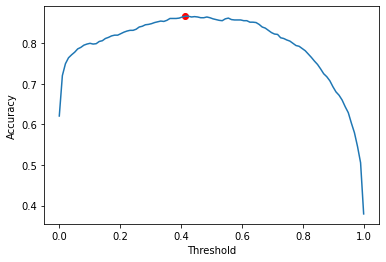

In [35]:
fig, ax = plt.subplots(1)
ax.plot(c_range, accuracies)
ax.scatter(c_range[np.argmax(accuracies)], np.max(accuracies), color='r')
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')
fig_path = model_path+'S1-Accuracy.png'
plt.savefig(fig_path)

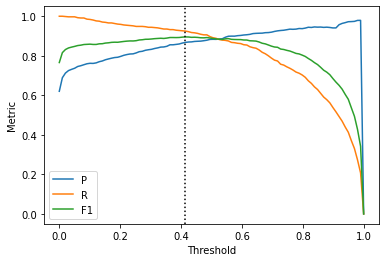

In [36]:
fig, ax = plt.subplots(1)
ax.plot(c_range, precisions, label='P')
ax.plot(c_range, recalls, label='R')
ax.plot(c_range, f1_scores, label='F1')
ax.axvline(c_range[np.argmax(accuracies)], color='black', linestyle=':')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Metric')
fig_path = model_path+'S1-Metrics.png'

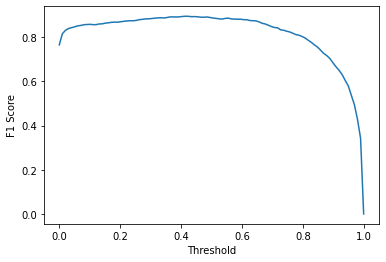

In [25]:
fig, ax = plt.subplots(1)
ax.plot(c_range, f1_scores)
ax.set_xlabel('Threshold')
ax.set_ylabel('F1 Score')
fig_path = model_path+'S1-F1_score.png'
plt.savefig(fig_path)

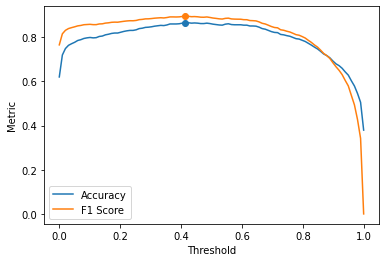

In [26]:
fig, ax = plt.subplots(1)
ax.plot(c_range, accuracies, label='Accuracy')
ax.plot(c_range, f1_scores, label='F1 Score')
ax.scatter(c_range[np.argmax(accuracies)], np.max(accuracies))
ax.scatter(c_range[np.argmax(f1_scores)], np.max(f1_scores))
ax.set_xlabel('Threshold')
ax.set_ylabel('Metric')
ax.legend()
fig_path = model_path+'S1-metric.png'
plt.savefig(fig_path)

In [27]:
np.max(accuracies), c_range[np.argmax(accuracies)]

(0.8658759124087592, 0.4141414141414142)

In [28]:
np.max(f1_scores), c_range[np.argmax(f1_scores)]

(0.895373665480427, 0.4141414141414142)

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
preds = np.float_(test_target_probs>c_range[np.argmax(accuracies)])

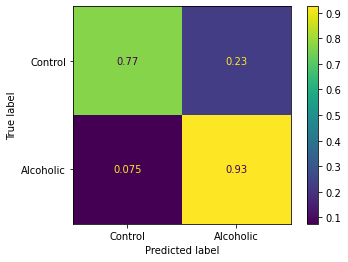

In [31]:
# Obtain the confusion matrix
cm = confusion_matrix(y_true = test_target, 
                      y_pred = preds, normalize='true')

# Plot it!

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.xticks(ticks = [0,1], labels=['Control','Alcoholic'])
plt.yticks(ticks = [0,1], labels=['Control','Alcoholic'])



fig_path = model_path+'S1-conf_mat.png'
plt.savefig(fig_path)

(array([218.,  59.,  48.,  40.,  42.,  41.,  67.,  73., 119., 389.]),
 array([1.2731608e-06, 1.0000113e-01, 2.0000099e-01, 3.0000085e-01,
        4.0000069e-01, 5.0000054e-01, 6.0000038e-01, 7.0000029e-01,
        8.0000013e-01, 8.9999998e-01, 9.9999982e-01], dtype=float32),
 <a list of 10 Patch objects>)

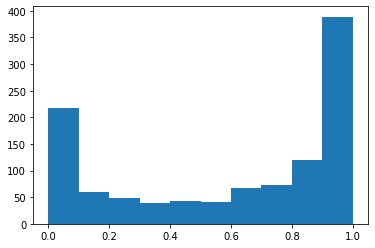

In [32]:
plt.hist(test_target_probs)

(array([416.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 680.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

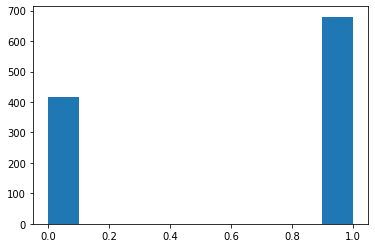

In [33]:
plt.hist(test_target)